**Batch Normalization 实践**

旨在分享：
- 了解BN的实现
- 观察BN的效果
- 知道BN在train和inference两个阶段的实现细节

基于tensorflow1.5.0，python3.6.8，试验数据集为mnist

In [1]:
import numpy as np, tensorflow as tf, tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print(tf.__version__)
import platform 
print(platform.python_version())

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
1.5.0
3.6.8


# 构造神经网络（无BN和有BN）
构建两个全连接神经网络：
- 一个是普通网络，包括2个隐层，1个输出层。
- 一个是有BN的网络，包括2个隐层，1个输出层。
第1层中的BN是我们自定义的，第2层和第3层中的BN是调用tensorflow实现。

定义输入占位符，定义三个层的权重，方便后面使用

In [2]:
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# 为BN层准备一个非常小的数字，防止出现分母为0的极端情况。
epsilon = 1e-3

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Layer 1 层：无BN

In [3]:
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

Layer 1 层：有BN（自定义BN层）

In [4]:
w1_BN = tf.Variable(w1_initial)

# 因为BN的引入，b的作用被BN层替代，省略。
z1_BN = tf.matmul(x,w1_BN)

# 计算加权和的均值和方差，0是指batch这个维度
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# 正则化
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# 新建两个变量scale and beta
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# 计算被还原的BN1，即BN文章里的y
BN1 = scale1 * z1_hat + beta1

# l1_BN = tf.nn.sigmoid(BN1)
l1_BN = tf.nn.relu(BN1)

Layer 2 层：无BN

In [5]:
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
# l2 = tf.nn.sigmoid(z2)
l2 = tf.nn.relu(z2)

Layer 2 层：有BN（使用tensorflow创建BN层）

In [6]:
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)

# 计算加权和的均值和方差，0是指batch这个维度
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])

# 新建两个变量scale and beta
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))

# 计算被还原的BN2，即BN文章里的y。使用
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)

# l2_BN = tf.nn.sigmoid(BN2)
l2_BN = tf.nn.relu(BN2)

Layer 3 层：无BN

In [7]:
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

Layer 3 层：有BN（使用tensorflow创建BN层）

In [8]:
# w3_BN = tf.Variable(w3_initial)
# b3_BN = tf.Variable(tf.zeros([10]))
# y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

w3_BN = tf.Variable(w3_initial)
z3_BN = tf.matmul(l2_BN,w3_BN)

batch_mean3, batch_var3 = tf.nn.moments(z3_BN,[0])
scale3 = tf.Variable(tf.ones([10]))
beta3 = tf.Variable(tf.zeros([10]))
BN3 = tf.nn.batch_normalization(z3_BN,batch_mean3,batch_var3,beta3,scale3,epsilon)

# print(BN3.get_shape())
y_BN  = tf.nn.softmax(BN3)

针对普通网络和BN网络，分别定义损失、优化器、精度三个op。
- 损失使用交叉熵，因为我们输出层的激活函数为softmax。
- 优化器用梯度下降

In [9]:
# 普通网络的损失
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
# BN网络的损失
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

# 普通网络的优化器
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
# BN网络的优化器
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

# 普通网络的accuracy
correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
# BN网络的accuracy_BN
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

Instructions for updating:
Use `argmax` instead


# 训练网络并对比学习曲线
- 训练普通网络、有BN网络，
- 对比训练阶段的学习曲线。
- 对比BN对输入加权和的影响。

首先是训练普通网络、有BN网络

In [10]:
# zs存放普通网络第2个隐层的非线性激活前的加权和向量。
# BNs存放BN网络第2个隐层的非线性激活前的加权和向量（经过了BN）。
# acc, acc_BN存放训练阶段，通过测试集测得的精度序列。用于绘制learning curve
zs, BNs, acc, acc_BN = [], [], [], []

# 开一个sess，同时跑train_step、train_step_BN
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(40000)):
    batch = mnist.train.next_batch(60)
    
    # 运行train_step，训练无BN网络
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    # 运行train_step_BN，训练有BN的网络
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    
    if i % 50 is 0:
        # 每50个batch，测一测精度，并把第二层的加权输入，没进BN层之前的z2，被BN层处理过的BN2，都算一遍
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
        # 保存训练阶段的精度记录，acc是无BN网络的记录，acc_BN是有BN网络的记录，
        acc.append(res[0])
        acc_BN.append(res[1])
        
        # 保存训练阶段的z2，BN2的历史记录
        zs.append(np.mean(res[2],axis=0)) 
        BNs.append(np.mean(res[3],axis=0))

zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

100%|████████████████████████████████████| 40000/40000 [06:54<00:00, 96.44it/s]


对比训练阶段的学习曲线：
绘制精度训练曲线的结果表明BN的加入，大大提升了训练效率。

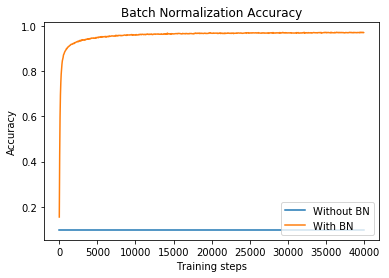

In [11]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
# ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

- zs与BNs

其中：
zs 来自无BN网络的第二个隐层的输入加权和向量，即下一步将喂给本层的激活函数。
BNs 来自有BN网络的第二个隐层的输入加权和经过BN层处理后的向量，即下一步也将喂给本层的激活函数。
- 效果：没有BN，则网络的加权和完全跑飞了；有BN，则加权和会被约束在0附近。



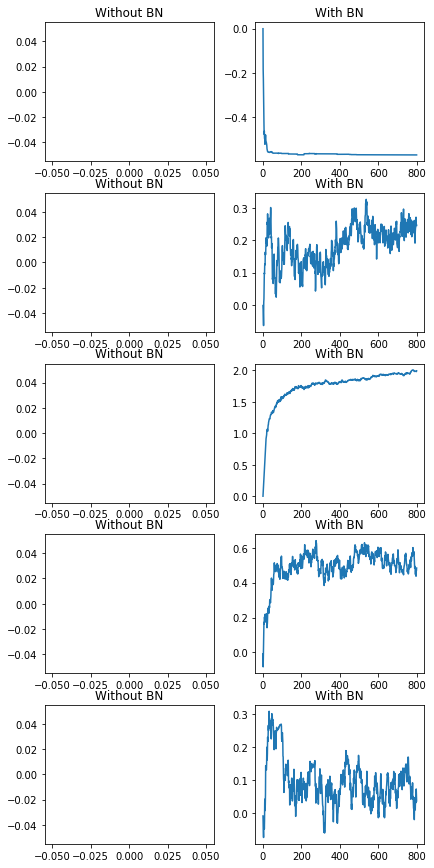

In [12]:
# 显示在无BN和有BN两个网络里，800次前向传播中第2个隐层的5个神经元的加权和的输入范围。
fig, axes = plt.subplots(5, 2, figsize=(6,12))
# fig, axes = plt.subplots(5, 2)
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    # [:,i]表示取其中一列，也就是对应神经网络中
    # print(zs[:,i].shape)
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])
plt.show()

# 测试阶段的问题
带有BN的网络，不能直接用于测试。
因为测试阶段每个样本如果是逐个输入，相当于batch_size=1,那么均值为自己，方差为0，正则化后将为0。
导致模型的输入永远是一个0值。因此预测将根据训练的权重输出一个大概率是错误的预测。

In [13]:
predictions = []
correct = 0
for i in range(100):
    pred, corr = sess.run([tf.arg_max(y_BN,1), accuracy_BN],
                         feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
    # 累加，最终用于求取100次预测的平均精度
    correct += corr
    # 保存每次预测的结果
    predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)
sess.close()
# 结果将是：不管输入的是什么照片，结果都将相同。因为每个图片在仅有自己的mini-batch上都被标准化为了全0向量。

PREDICTIONS: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
ACCURACY: 0.02


# 实际应用的细节

为了避免推理（or预测）时出现的问题，需要注意一下几点：
## 构造BN层
batch_norm_wrapper将实现在更为高级的功能，合二为一：
- 训练阶段，统计训练集均值和方差；
- 推理阶段，直接使用训练阶段的统计结果。

In [14]:
# batch_norm_wrapper 是对tensorflow中BN层实现的一个核心功能的重现。
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
# 其功能是：对于每个batch的每一层的加权输入
# 在训练阶段，统计方差和均值，一边记录和更新总体方差和均值。
# 在测试/评估阶段，直接使用训练时统计好的总体方差和均值。
def batch_norm_wrapper(inputs, is_training, decay = 0.999):

    # 每个BN层，引入了4个变量 scale beta pop_mean pop_var，其中:
    # scale beta 是可训练的，训练结束后被保存为模型参数
    # pop_mean pop_var 是不可训练，只在训练中进行统计，
    # pop_mean pop_var 最终保存为模型的变量。在测试时重构的计算图会接入该变量，只要载入训练参数即可。
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        # 以下为训练时的BN计算图构造
        # batch_mean、batch_var在一个batch里的每一层，在前向传播时会计算一次，
        # 在反传时通过它来计算本层输入加权和的梯度，仅仅作为整个网络传递梯度的功能。在训练结束后被废弃。
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        
        # 通过移动指数平均的方式，把每一个batch的统计量汇总进来，更新总体统计量的估计值pop_mean、pop_var
        # assign构建计算图一个operation，即把pop_mean * decay + batch_mean * (1 - decay) 赋值给pop_mean
        train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))

        # 确保本层的train_mean、train_var这两个operation都执行了，才进行BN。
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,batch_mean, batch_var, beta, scale, epsilon)
    else:
        # 以下为测试时的BN计算图构造，即直接载入已训练模型的beta, scale,已训练模型中保存的pop_mean, pop_var
        return tf.nn.batch_normalization(inputs,pop_mean, pop_var, beta, scale, epsilon)

构造计算图，其中通过调用上面定义好的BN包装器，实现BN层的简洁添加。

In [15]:
def build_graph(is_training):
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y_")

    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x,w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1,w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)

    w3 = tf.Variable(w3_initial)
    # b3 = tf.Variable(tf.zeros([10]))
    # y  = tf.nn.softmax(tf.matmul(l2, w3))
    z3 = tf.matmul(l2,w3)
    bn3 = batch_norm_wrapper(z3, is_training)
    y  = tf.nn.softmax(bn3)


    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')

    return (x, y_), train_step, accuracy, y

训练阶段：
- 通过传入is_training=True，开启计算图的方差和均值统计操作。
- 训练结束后，保存模型，包含计算图和参数，实际上只有参数会被用到，因为在预测时会新建计算图。

In [16]:
tf.reset_default_graph()
(x, y_), train_step, accuracy, _,= build_graph(is_training=True)

acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 200 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
            # print('batch:',i,'    accuracy:',res[0])
    # 保存模型，注意该模型是不可用的。因为其计算图是训练的计算图。
    saver=tf.train.Saver()
    # saved_model = saver.save(sess, './temp-bn-save')
    saver.save(sess, './bn_test/temp-bn-save')
    writer=tf.summary.FileWriter('./improved_graph2',sess.graph)
    writer.flush()
    writer.close()
print("Final accuracy:", acc[-1])


100%|███████████████████████████████████| 10000/10000 [00:38<00:00, 260.31it/s]


Final accuracy: 0.9538


测试阶段：先构造测试/评估的计算图，再把训练好的模型参数载入到这个计算图中。 

In [17]:
tf.reset_default_graph()
# (x, y_), _, accuracy, y, saver = build_graph(is_training=False)
(x, y_), _, accuracy, y = build_graph(is_training=False)

predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 读取训练时模型，将学到的权重参数、估计的总体均值、方差，通过restore，载入到运行的计算图中。
    saver=tf.train.Saver()
    saver.restore(sess, './bn_test/temp-bn-save')
    saver.save(sess, './bn_release/temp-bn-save')
    
    for i in range(100):
        pred, corr = sess.run([tf.arg_max(y,1), accuracy],
                             feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        correct += corr
        predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)


INFO:tensorflow:Restoring parameters from ./bn_test/temp-bn-save
PREDICTIONS: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 7, 7, 8, 9, 3, 7, 4, 1, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
ACCURACY: 0.97


# 其他可以做的试验
## BN到添加位置试验
在加权和后 vs 在加权和前
靠近输入层 vs 靠近输出层

## BN的添加量试验
在每一层都加BN vs 在少数几层加BN 
## BN对学习率的影响
大学习率 vs 小学习率
## Batch_size对BN效果的影响
小batch_size vs 大batch_size